In [186]:
%matplotlib inline

## 1D - Least squares polynomial fit

### The generative probabilistic model
Here we will generate a synthetic dataset from a first order model **$y = \theta_1 \cdot u + \theta_0$** and add some Gaussian noise to simulate sampling of the data, giving us: **$y_{measured} = \theta_1 \cdot u + \theta_0 + err$** where:  
$y$ = output  
$u$ = input    
$\theta_{0,1}$ = model parameters   
$err$ = sampling noise

Given the input $u$ and the measured data **$y_{measured}$** we will try to estimate the first oreder model coeffitienst $\hat{\theta}_{0,1}$ using the Least sqaures method.

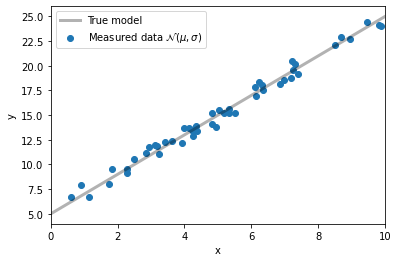

In [187]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters for 1D polynomial model 
theta_0 = 5.0
theta_1 = 2.0

# Generate some synthetic data from the model -> y = thetha_1 * u + theta_0
N = 50
u = np.sort(10 * np.random.rand(N))
y = theta_1 * u + theta_0

# Generate some Gaussian (normal) noise
mu, sigma = 0, 0.5 # mean and standard deviation
err = np.random.normal(mu, sigma, N)

# Measured output
y += err

plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, 10, 500)
plt.plot(u0, theta_1 * u0 + theta_0, "k", alpha=0.3, lw=3, label="True model")
plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

### Given the sampled data we can estimate the underlying model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (u^T\cdot u)^{-1}(u^T\cdot y)$

### Step 1 - rewrite the model in matrix form
$y_{measured} = \theta_1 \cdot u + \theta_0 + err = [ \theta_1 \; \theta_0 ] \cdot [u \; 1]^T + err$

In [188]:
u_vec = np.reshape(u,(N,1))
print(f"u :\n{u_vec[0:5]} \n")
u_vec = np.append(u_vec, np.ones((N,1)),axis=1)
print(f"u, 1 :\n{u_vec[0:5,:]}")

u :
[[0.59677897]
 [0.9210494 ]
 [1.15618395]
 [1.75451756]
 [1.8249173 ]] 

u, 1 :
[[0.59677897 1.        ]
 [0.9210494  1.        ]
 [1.15618395 1.        ]
 [1.75451756 1.        ]
 [1.8249173  1.        ]]


### Step 2   

calculate $(u^T \cdot u)^{-1}$

In [189]:
u_transpose_dot_u = np.dot(u_vec.T,u_vec)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
print(u_transpose_dot_u_inv)

[[ 0.00370065 -0.01857201]
 [-0.01857201  0.11320512]]


### Step 3  

calculate $(u^T \cdot y)$

In [190]:
u_transpose_dot_y = np.dot(u_vec.T,y)  # calculating dot product
print(u_transpose_dot_y)

[4314.71166139  754.48986232]


### Step 4 

solve for $\hat{\theta}$

[theta_1_hat theta_0_hat]: [1.95485083 5.27922455]
[theta_1 theta_0]: [2.0, 5.0]


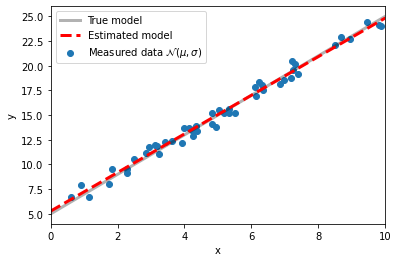

In [194]:
theta_hat = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
print(f"[theta_1_hat theta_0_hat]: {theta_hat}")
print(f"[theta_1 theta_0]: {[theta_1, theta_0]}")

plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(0, 10, 500)
plt.plot(u0, theta_1 * u0 + theta_0, "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, theta_hat[0] * u0 + theta_hat[1], "r--",  lw=3, label="Estimated model")
plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");